In [20]:
import bcolz
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
def load_array(fname):
    return bcolz.open(fname)[:]

In [3]:
train_ids = load_array("data/train_ids.arr")
x_train = load_array("data/x_train.arr")
y_train = load_array("data/y_train.arr")
# test_ids = load_array("data/test_ids.arr")
# x_test = load_array("data/x_test.arr")

In [13]:
im_width = x_train.shape[1]
im_height = x_train.shape[2]
im_chan = x_train.shape[3]

In [14]:
x_train.shape, y_train.shape, x_test.shape, im_width, im_height, im_chan

((4000, 128, 128, 1), (4000, 128, 128, 1), (18000, 128, 128, 1), 128, 128, 1)

We define the metric we are going to use to evaluate: mean average precision at different intersection over union (IoU) thresholds

In [21]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

Now we define the actual Unet model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

In [16]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

In [17]:
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [18]:
model = Model(inputs=[inputs], outputs=[outputs])

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_poolin

In [25]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('models/unet-simple.h5', verbose=1, save_best_only=True)
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 165s 46ms/step - loss: 0.5454 - mean_iou: 0.3783 - val_loss: 0.4739 - val_mean_iou: 0.3778

Epoch 00001: val_loss improved from inf to 0.47394, saving model to model-tgs-salt-1.h5
Epoch 2/30
3600/3600 [==============================] - 179s 50ms/step - loss: 0.4661 - mean_iou: 0.3815 - val_loss: 0.3872 - val_mean_iou: 0.3936

Epoch 00002: val_loss improved from 0.47394 to 0.38720, saving model to model-tgs-salt-1.h5
Epoch 3/30
3600/3600 [==============================] - 195s 54ms/step - loss: 0.5222 - mean_iou: 0.4005 - val_loss: 0.5307 - val_mean_iou: 0.3978

Epoch 00003: val_loss did not improve from 0.38720
Epoch 4/30
3600/3600 [==============================] - 181s 50ms/step - loss: 0.4113 - mean_iou: 0.4074 - val_loss: 0.3659 - val_mean_iou: 0.4227

Epoch 00004: val_loss improved from 0.38720 to 0.36594, saving model to model-tgs-salt-1.h5
Epoch 5/30
3600/3600 [================

## Check the predictions

Let's check one prediction

In [31]:
pred_train = model.predict(x_train, verbose=1)

4000/4000 [==============================] - 67s 17ms/step


In [28]:
pred_train.shape

(4000, 128, 128, 1)

In [32]:
import random
from tensorflow.keras.preprocessing import image as image_utils

In [73]:
n = random.randint(1, pred_train.shape[0])

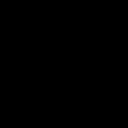

In [74]:
image_utils.array_to_img(y_train[n])

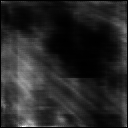

In [75]:
image_utils.array_to_img(pred_train[n])